In [32]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import networkx as nx
from scipy.optimize import minimize

from docplex.mp.model import Model
from collections import defaultdict
from openqaoa.problems.converters import FromDocplex2IsingModel # function to translate docplex problems into Ising Hamiltonians

import networkx as nx
import numpy as np
import time
from qiskit import QuantumCircuit, transpile
from qiskit.providers.basic_provider import BasicSimulator

from qiskit_aer import AerSimulator

# from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

# service = QiskitRuntimeService(name="Purdue")

# backend = BasicSimulator()
backend = AerSimulator()
# backend_cloud = service.backend("ibmq_qasm_simulator")

colors = plt.get_cmap("jet", 20)

label_size = 14
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size 
plt.rcParams['axes.labelsize'] = label_size 
plt.rcParams['legend.fontsize'] = label_size 

In [33]:
def MIS_QUBO(G, penalty=2):
    # MIS model as a QUBO problem
    mdl = Model('MIS')
    num_vertices = G.number_of_nodes()

    x = {i: mdl.binary_var(name=f"x_{i}") for i in range(num_vertices)}
    mdl.minimize(-mdl.sum(x) + penalty * mdl.sum(
        x[i] * x[j] for (i, j) in G.edges
    ))
    return mdl

def cost(x, G):
    obj = 0
    for i, j in G.edges():
        if x[i] + x[j] == "11":
            obj += 2
    return - x.count("1") + obj

def energy(x, hamiltonian):
    obj = 0
    spin = {"1":-1, "0":1}
    for k, v in hamiltonian.items():
        if len(k) == 2:
            obj += v * spin[x[k[0]]] * spin[x[k[1]]]
        elif len(k) == 1:
            obj += v * spin[x[k[0]]]
        else:
            print(k, v)
    return obj


def qaoa_circ(hamiltonian, gammas, betas, n_qubits):
    p = len(gammas)
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))
    for ii in range(p):
        for qbits, value in hamiltonian.items():
            if len(qbits) == 1:
                qc.rz(2*gammas[ii]*float(value), qbits[0])
        for qbits, value in hamiltonian.items():
            if len(qbits) == 2:
                qc.rzz(2*gammas[ii]*float(value), *qbits)
        qc.rx(-2*betas[ii], range(n_qubits))
    qc = qc.reverse_bits()
    qc.measure_all()
    return qc

In [94]:
np.random.seed(1)
problems = np.load("./Data/MIS/problems.npy", allow_pickle=True).item()
nodes_list_qubo = range(31, 41)
prob_G = 0.4
random_cases = 100
# Generate graphs with the above condition for different number of nodes
for nodes in nodes_list_qubo: 
    print(f"-------     qubits: {nodes}    ---------")
    problems[nodes] = {}
    for kk in range(random_cases):
        problems[nodes][kk] = {}
        G = nx.Graph()
        G.add_nodes_from(range(nodes))
        for i in range(nodes - 1):
            for j in range(i+1, nodes):
                if np.random.rand() < prob_G:
                    G.add_edge(i,j)
        problems[nodes][kk]["G"] = G
        mdl = MIS_QUBO(G)
        ising_hamiltonian = FromDocplex2IsingModel(mdl).ising_model
        max_w = np.max(np.abs(ising_hamiltonian.weights))
        # max_w = np.max(np.abs([w for w, qbs in zip(ising_hamiltonian.weights, ising_hamiltonian.terms) if len(qbs)==2]))
        ising_hamiltonian.weights = [w/max_w for w in ising_hamiltonian.weights]
        ising_hamiltonian.constant = ising_hamiltonian.constant/max_w
        problems[nodes][kk]["ising"] = {tuple(k): v for k, v in zip(ising_hamiltonian.terms, ising_hamiltonian.weights) if abs(v) > 1e-6}
        mdl.solve()
        problems[nodes][kk]["sol"] = "".join(str(round(mdl.solution.get_value(var))) for var in mdl.iter_binary_vars())
        problems[nodes][kk]["opt_cost"] = cost(problems[nodes][kk]["sol"], G)
        problems[nodes][kk]["opt_energy"] = energy(problems[nodes][kk]["sol"], problems[nodes][kk]["ising"])#*max_w + max_w* ising_hamiltonian.constant

# np.save("./Data/MIS/problems.npy", problems)

-------     qubits: 31    ---------
-------     qubits: 32    ---------
-------     qubits: 33    ---------
-------     qubits: 34    ---------
-------     qubits: 35    ---------
-------     qubits: 36    ---------
-------     qubits: 37    ---------
-------     qubits: 38    ---------
-------     qubits: 39    ---------
-------     qubits: 40    ---------


In [34]:
problems = np.load("./Data/MIS/problems.npy", allow_pickle=True).item()

In [106]:
problems_hpc = {nq:{kk:{"ising":problems[nq][kk]["ising"], "sol":problems[nq][kk]["sol"]} for kk in range(100)} for nq in [25,30,35]}
# np.save("./Data/MIS/problems_hpc.npy", problems_hpc)

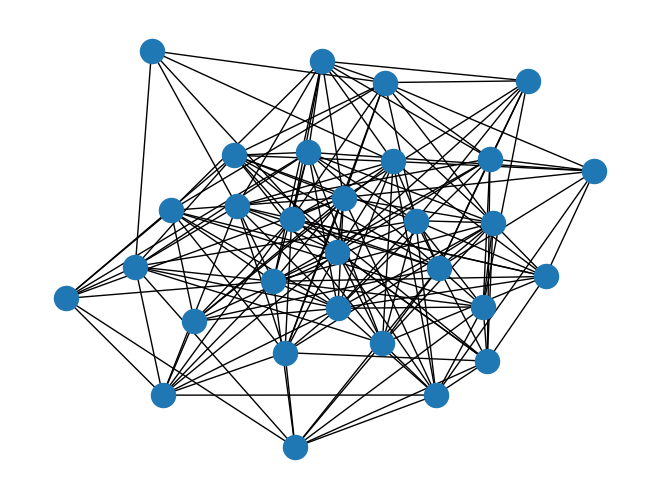

In [12]:
nx.draw(problems[30][0]["G"])

# Results: unique case

In [36]:
method = "hpc"
nqs = [35]
delta_betas = {25:{"local": [0.2, 0.3,0.4, 0.5, 0.6], "hpc":[0.3,0.4,0.5,0.6]},
               30:{"hpc":{0:[0.3,0.4,0.5,0.6], 1:[0.4,0.45,0.5,0.55]}},
               35:{"hpc":{0:[0.4, 0.45, 0.5, 0.55]}}}
delta_gammas = {25:{"local": [1.5, 2.0, 2.5, 3, 3.5, 4, 4.5], "hpc":[3,3.5,4,4.5,5,5.5,6]},
                30:{"hpc":{0:[3,3.5,4,4.5,5,5.5,6], 1:[4.0, 4.25, 4.5, 4.75, 5.0]}},
                35:{"hpc":{0:[4.0, 4.25, 4.5, 4.75, 5.0]}}}
ps = [10,25,50,100,200]
# ps = [10,25]
cases = [0]
shots = 1000
results = np.load("./Data/MIS/results.npy", allow_pickle=True).item()
for nq in nqs:
    print(f"---------   nq = {nq}   --------")
    results[nq] = {}
    for kk in cases:
        print(f"---------   case = {kk}   --------")
        results[nq][kk] = {}
        opt_energy = round(problems[nq][kk]["opt_energy"],3)
        hamiltonian = problems[nq][kk]["ising"]
        G = problems[nq][kk]["G"]
        results[nq][kk]["energies"] = {}
        results[nq][kk]["landscape"]={}
        results[nq][kk]["best"] = {}
        for p in ps:
            best_probability = 0
            print(f"---------   p = {p}   --------")
            results[nq][kk]["energies"][p] = {}
            results[nq][kk]["landscape"][p] = {"energy":np.zeros((len(delta_betas[nq][method][kk]), len(delta_gammas[nq][method][kk]))), "probability":np.zeros((len(delta_betas[nq][method][kk]), len(delta_gammas[nq][method][kk])))}
            nn=0
            for i, delta_beta in enumerate(delta_betas[nq][method][kk]):
                for j, delta_gamma in enumerate(delta_gammas[nq][method][kk]):
                    if method == "local":
                        gammas = np.arange(1, p+1) * delta_gamma/p
                        betas = np.arange(1, p+1)[::-1] * delta_beta/p
                        qc = qaoa_circ(hamiltonian, gammas, betas, nq)
                        qc = transpile(qc, backend=backend)
                        samples = backend.run(qc, shots=shots).result().get_counts()
                    else:
                        with open(f"./Data/MIS/samples_hpc/{nq}/{kk}/{p}/{nn}.out", "r") as file:
                            lines = file.readlines()
                        samples = defaultdict(int)
                        for line in lines[2:]:
                            columns = line.split()
                            samples[columns[0][1:-1][::-1]] += int(columns[-1])
                        shots = 10000
                        nn += 1
                    energies = defaultdict(int)
                    mean_energy = 0
                    for sample, c in samples.items():
                        e = round(energy(sample, hamiltonian), 3)
                        energies[e] += c
                        mean_energy += e*c
                    mean_energy /= shots 
                    probability = energies[opt_energy]/shots if opt_energy in energies else 0
                    results[nq][kk]["energies"][p][(delta_beta, delta_gamma)] = energies
                    results[nq][kk]["landscape"][p]["energy"][i,j] = mean_energy
                    results[nq][kk]["landscape"][p]["probability"][i,j] = probability
                    if probability > best_probability:
                        best_probability = probability
                        results[nq][kk]["best"][p] = {"probabiliy":probability, "delta_beta":delta_beta, "delta_gamma":delta_gamma, "energy":mean_energy}
                        print(f"beta:{delta_beta} | gamma: {delta_gamma}, probability: {probability}, mean energy: {mean_energy}")
np.save("./Data/MIS/results.npy", results)

---------   nq = 35   --------
---------   case = 0   --------
---------   p = 10   --------
beta:0.4 | gamma: 4.0, probability: 0.0028, mean energy: -11.433576900000064
beta:0.4 | gamma: 4.5, probability: 0.0035, mean energy: -11.295803400000045
---------   p = 25   --------
beta:0.4 | gamma: 4.0, probability: 0.0222, mean energy: -11.880618899999936
beta:0.4 | gamma: 4.25, probability: 0.0291, mean energy: -11.877391600000003
beta:0.4 | gamma: 4.5, probability: 0.039, mean energy: -11.870937099999951
beta:0.4 | gamma: 4.75, probability: 0.0434, mean energy: -11.861515199999975
beta:0.4 | gamma: 5.0, probability: 0.0466, mean energy: -11.846820500000007
beta:0.5 | gamma: 4.5, probability: 0.0493, mean energy: -11.885834400000041
beta:0.5 | gamma: 4.75, probability: 0.0543, mean energy: -11.865965300000033
beta:0.5 | gamma: 5.0, probability: 0.0551, mean energy: -11.840358200000065
---------   p = 50   --------
beta:0.4 | gamma: 4.0, probability: 0.1098, mean energy: -12.03700680000009

In [76]:
ps = [10,25,50,100,200]
# ps = [25]
nqs = [35]
cases = range(1, 100)
shots = 1000
results = np.load("./Data/MIS/results.npy", allow_pickle=True).item()
for nq in nqs:
    print(f"---------   nq = {nq}   --------")
    for kk in cases:
        print(f"---------   case = {kk}   --------")
        results[nq][kk] = {}
        opt_energy = round(problems[nq][kk]["opt_energy"],3)
        hamiltonian = problems[nq][kk]["ising"]
        G = problems[nq][kk]["G"]
        results[nq][kk]["best"] = {}
        for p in ps:
            if method == "local":
                
                    if nq > 5 and nq < 21: 
                        delta_gamma = np.mean([results[i][0]["best"][p]["delta_gamma"] for i in [nq-1, nq, nq+1]])
                        delta_beta = np.mean([results[i][0]["best"][p]["delta_beta"] for i in [nq-1, nq, nq+1]])
                    elif nq == 5:    
                        delta_gamma = np.mean([results[i][0]["best"][p]["delta_gamma"] for i in [nq, nq+1]])
                        delta_beta = np.mean([results[i][0]["best"][p]["delta_beta"] for i in [nq, nq+1]])
                    elif nq == 21:    
                        delta_gamma = np.mean([results[i][0]["best"][p]["delta_gamma"] for i in [nq-1, nq]])
                        delta_beta = np.mean([results[i][0]["best"][p]["delta_beta"] for i in [nq-1, nq]])
                    else:
                        print("here")
                    gammas = np.arange(1, p+1) * delta_gamma/p
                    betas = np.arange(1, p+1)[::-1] * delta_beta/p
                    qc = qaoa_circ(hamiltonian, gammas, betas, nq)
                    qc = transpile(qc, backend=backend)
                    samples = backend.run(qc, shots=shots).result().get_counts()
            elif method == "hpc":
                with open(f"./Data/MIS/samples_hpc/{nq}/{kk}/{p}/0.out", "r") as file:
                    lines = file.readlines()
                samples = defaultdict(int)
                for line in lines[2:]:
                    columns = line.split()
                    samples[columns[0][1:-1][::-1]] += int(columns[-1])
                shots = 10000
                
            energies = defaultdict(int)
            mean_energy = 0
            for sample, c in samples.items():
                e = round(energy(sample, hamiltonian), 3)
                energies[e] += c
                mean_energy += e*c
            mean_energy /= shots 
            probability = energies[opt_energy]/shots if opt_energy in energies else 0
            results[nq][kk]["best"][p] = {"probabiliy":probability, "delta_beta":delta_beta, "delta_gamma":delta_gamma, "energy":mean_energy}
            print(f"p:{p} | beta:{delta_beta} | gamma: {delta_gamma}, probability: {probability}, mean energy: {mean_energy}")
np.save("./Data/MIS/results.npy", results)

---------   nq = 35   --------
---------   case = 1   --------
p:10 | beta:0.55 | gamma: 5.0, probability: 0.0156, mean energy: -10.623342799999953
p:25 | beta:0.55 | gamma: 5.0, probability: 0.2863, mean energy: -11.205546999999903
p:50 | beta:0.55 | gamma: 5.0, probability: 0.6718, mean energy: -11.300919599999892
p:100 | beta:0.55 | gamma: 5.0, probability: 0.8259, mean energy: -11.209415600000089
p:200 | beta:0.55 | gamma: 5.0, probability: 0.909, mean energy: -11.298511400000018
---------   case = 2   --------
p:10 | beta:0.55 | gamma: 5.0, probability: 0.0022, mean energy: -11.113646700000038
p:25 | beta:0.55 | gamma: 5.0, probability: 0.0566, mean energy: -11.724378800000046
p:50 | beta:0.55 | gamma: 5.0, probability: 0.1919, mean energy: -11.869280400000088
p:100 | beta:0.55 | gamma: 5.0, probability: 0.493, mean energy: -11.856389200000013
p:200 | beta:0.55 | gamma: 5.0, probability: 0.7824, mean energy: -11.948509599999985
---------   case = 3   --------
p:10 | beta:0.55 | ga

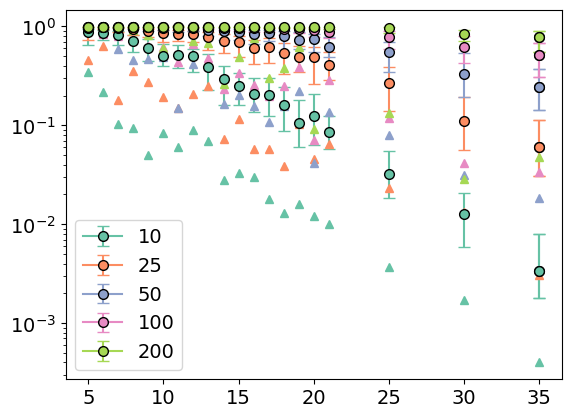

In [110]:
colors = plt.get_cmap("Set2")
results = np.load("./Data/MIS/results.npy", allow_pickle=True).item()

fig, ax  = plt.subplots()
sort = defaultdict(dict)
for i, p in enumerate([10,25,50,100,200]):
    for nq in sorted(results.keys()):
        y = [results[nq][kk]["best"][p]["probabiliy"] for kk in results[nq].keys()]
        quartiles = np.percentile(np.array(y), [25, 50, 75])
        sort[p][nq] = quartiles[1]
        ax.errorbar(nq, quartiles[1], yerr=[[quartiles[1] - quartiles[0]],[quartiles[2] - quartiles[1]]], marker="o", color=colors(i), capsize=4, markersize=7, markeredgecolor="black")
    ax.errorbar(nq, quartiles[1], yerr=[[quartiles[1] - quartiles[0]],[quartiles[2] - quartiles[1]]], marker="o", color=colors(i), capsize=4, markersize=7, markeredgecolor="black", label=p)

    y_min = [np.min([results[nq][kk]["best"][p]["probabiliy"] for kk in results[nq].keys()]) for nq in sorted(results.keys())]
    std = [np.std([results[nq][kk]["best"][p]["probabiliy"] for kk in results[nq].keys()]) for nq in sorted(results.keys())]
    # plt.errorbar(sorted(results.keys()), y, std , marker="o", label=p, color=colors(3*i), capsize=3)
    ax.plot(sorted(results.keys()), y_min , marker="^", linewidth=0, color=colors(i))
nqs = range(5, 20)
# plt.plot(nqs, [1/2**nq for nq in nqs], linestyle="--", color="black")
ax.legend()
ax.set_yscale("log")

Text(0.5, 0, '$p$')

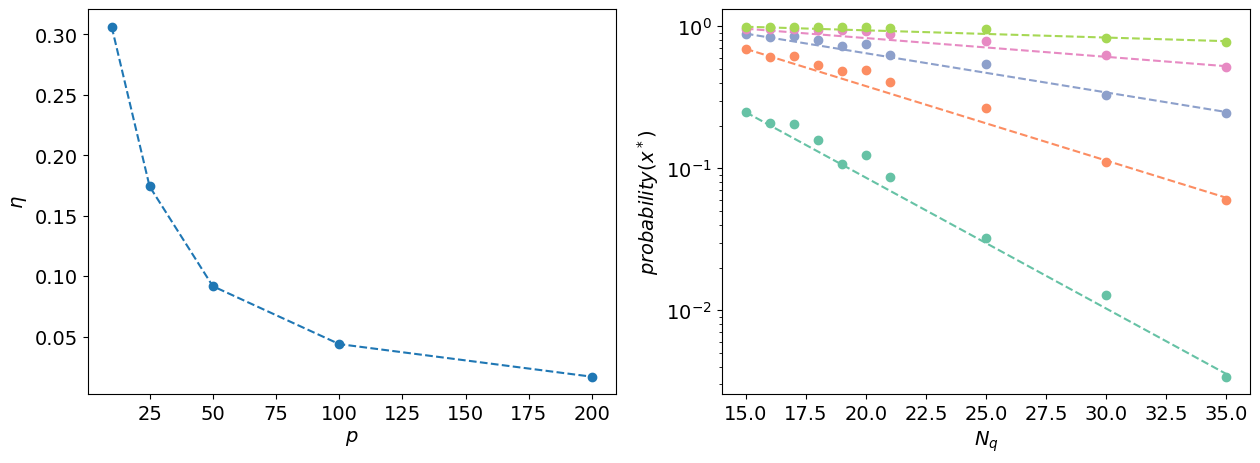

In [111]:
def func(x, p, nqs, y_real):
    """C:constant, eta:important value of the scale"""
    eta = x[0]
    C = x[1]
    y_eff = np.array([-eta*(nq - nqs[0]) for nq in nqs])
    return ((y_eff[:-1] - y_real[:-1])**2).mean() +  (y_eff[-1] - y_real[-1])**2

colors = plt.get_cmap("Set2")
ps = [10,25,50,100,200]
etas = {}
Cs = {}
error = {}
fig, ax = plt.subplots(1,2, figsize=(15,5))
for p in ps:
    nqs = list(range(15,22)) + [25,30,35]
    y_real = [np.log2(sort[p][nq]/sort[p][nqs[0]]) for nq in nqs]
    x0 = [0.5 , 0.1]
    sol = minimize(func, x0, args=(p, nqs, y_real))
    etas[p] = sol.x[0]
    Cs[p] = sol.x[1]
    error[p] = sol.fun

ax[0].plot(sorted(ps), [etas[p] for p in sorted(ps)], marker="o", linestyle="--")
# ax[0].plot(sorted(ps), [etas[ps[0]] for p in sorted(ps)], marker="o", linestyle=":")

for i, p in enumerate(sort.keys()):
    ax[1].plot(nqs, [np.mean(sort[p][nq]) for nq in nqs], marker="o", linewidth=0, color=colors(i))
    ax[1].plot(nqs, [sort[p][nqs[0]] * 2**(-etas[p]*(nq - nqs[0])) for nq in nqs], linestyle="--", color=colors(i))
    # ax[1].plot(nqs, [sort[p][nqs[0]] * 2**(-etas[ps[0]]*(nq - nqs[0])) for nq in nqs], linestyle=":", color=colors(i))

ax[1].set_yscale("log")
ax[1].set_ylabel(r"$probability(x^*)$")
ax[1].set_xlabel(r"$N_q$")
ax[0].set_ylabel(r"$\eta$")
ax[0].set_xlabel(r"$p$")
# ax[0].set_ylim(0,10)

Text(0.5, 0, 'Nq')

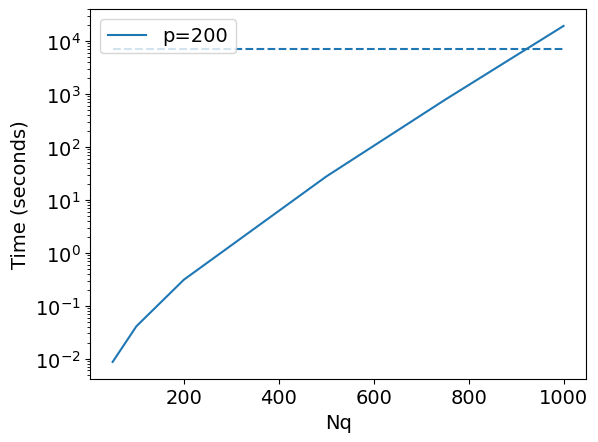

In [119]:

nq = 500
nqs_v = [50, 100, 200, 500, 750, 1000]
p = 100
# plt.plot(nqs_v, [np.log(1-0.99) / np.log(1-sort[p][nqs[0]] * 2**(-etas[p]*(nq - nqs[0]))) * 3 * nq * p * 68e-9  for nq in nqs_v], label=f"p={p}")
p = 200
overlap = 0.001
plt.plot(nqs_v, [np.log(1-0.99) / np.log(1-sort[p][nqs[0]] * 2**(-etas[p]*(nq - nqs[0]))) * 3 * nq * p * 68e-9   for nq in nqs_v], label=f"p={p}")
plt.hlines(7200.00, 50, 1000, linestyle="--")
plt.yscale("log")
plt.legend()
plt.ylabel("Time (seconds)")
plt.xlabel("Nq")

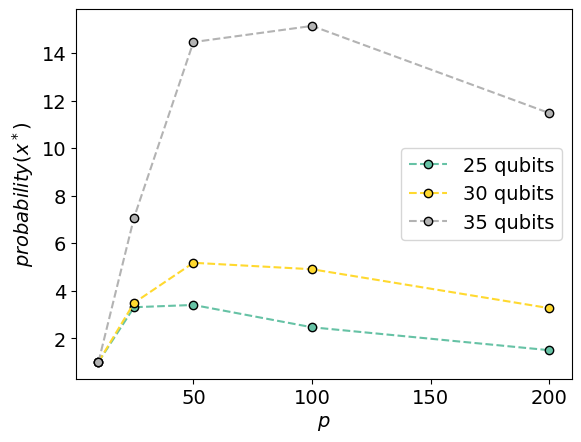

In [106]:
nq = 35
colors = plt.get_cmap("Set2")
fig, ax = plt.subplots()
for nq in [25,30,35]:
    ax.plot(ps, [10*sort[p][nq]/sort[10][nq]/p for p in ps], marker="o", linestyle="--", color=colors(nq-25), label=f"{nq} qubits", markeredgecolor="black")
# ax.set_yscale("log")
ax.set_ylabel(r"$probability(x^*)$")
ax.set_xlabel(r"$p$")
ax.legend()

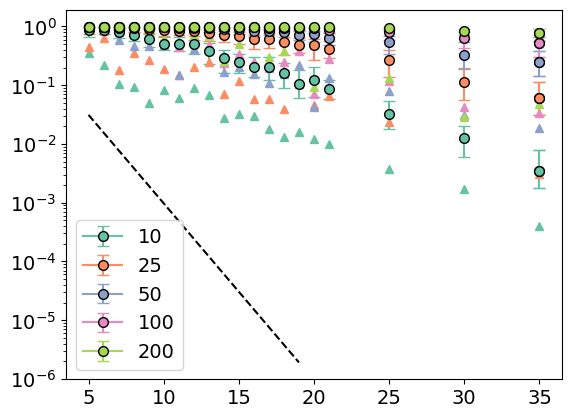

In [90]:
colors = plt.get_cmap("Set2")
for i, p in enumerate([10,25,50,100,200]):
    for nq in sorted(results.keys()):
        y = [results[nq][kk]["best"][p]["probabiliy"] for kk in results[nq].keys()]
        quartiles = np.percentile(np.array(y), [25, 50, 75])
        plt.errorbar(nq, quartiles[1], yerr=[[quartiles[1] - quartiles[0]],[quartiles[2] - quartiles[1]]], marker="o", color=colors(i), capsize=4, markersize=7, markeredgecolor="black")
    plt.errorbar(nq, quartiles[1], yerr=[[quartiles[1] - quartiles[0]],[quartiles[2] - quartiles[1]]], marker="o", color=colors(i), capsize=4, markersize=7, markeredgecolor="black", label=p)

    y_min = [np.min([results[nq][kk]["best"][p]["probabiliy"] for kk in results[nq].keys()]) for nq in sorted(results.keys())]
    std = [np.std([results[nq][kk]["best"][p]["probabiliy"] for kk in results[nq].keys()]) for nq in sorted(results.keys())]
    # plt.errorbar(sorted(results.keys()), y, std , marker="o", label=p, color=colors(3*i), capsize=3)
    plt.plot(sorted(results.keys()), y_min , marker="^", linewidth=0, color=colors(i))
nqs = range(5, 20)
plt.plot(nqs, [1/2**nq for nq in nqs], linestyle="--", color="black")
plt.legend()
plt.yscale("log")

Text(0, 0.5, '$\\gamma$')

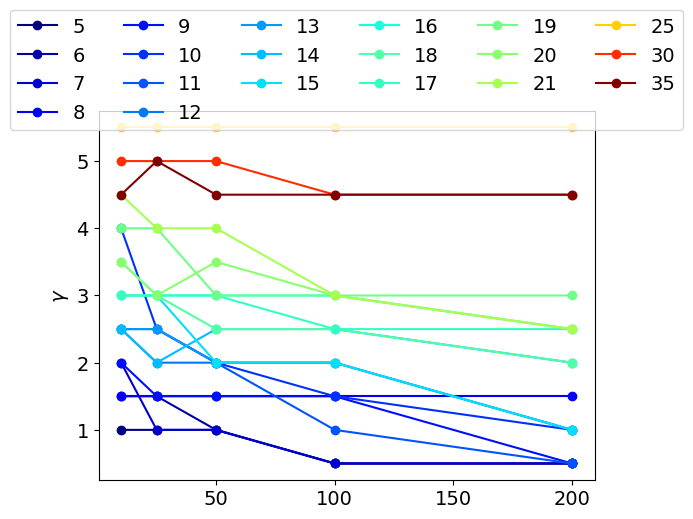

In [43]:
colors = plt.get_cmap("jet", 30)
kk = 0
for nq in results.keys():
    plt.plot(results[nq][kk]["best"].keys(), [results[nq][kk]["best"][p]["delta_gamma"] for p in results[nq][kk]["best"].keys()], marker="o",color= colors(nq-5), label=nq)
plt.legend(loc="upper center", bbox_to_anchor=(0.5,1.3), ncol=6)
plt.ylabel(r"$\gamma$")

Text(0, 0.5, '$\\beta$')

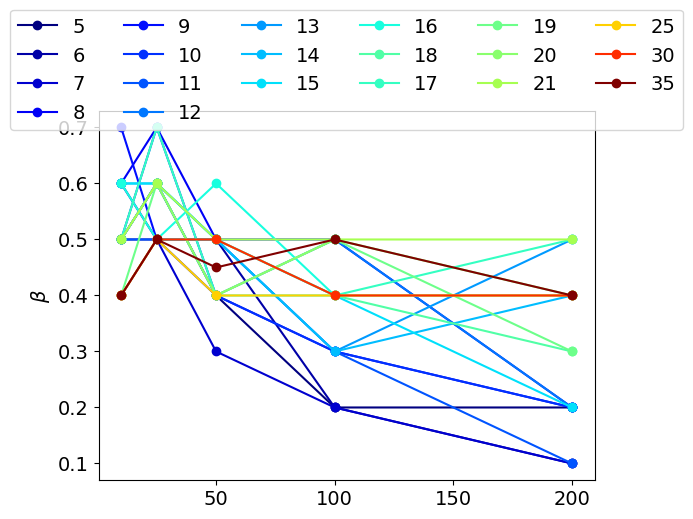

In [44]:
colors = plt.get_cmap("jet", 30)
kk = 0
for nq in results.keys():
    plt.plot(results[nq][kk]["best"].keys(), [results[nq][kk]["best"][p]["delta_beta"] for p in results[nq][kk]["best"].keys()], marker="o",color= colors(nq-5), label=nq)
plt.legend(loc="upper center", bbox_to_anchor=(0.5,1.3), ncol=6)
plt.ylabel(r"$\beta$")

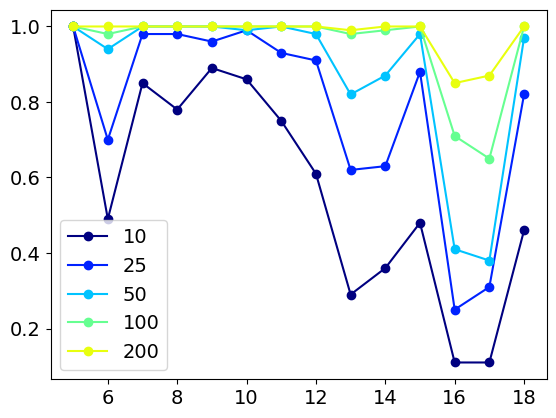

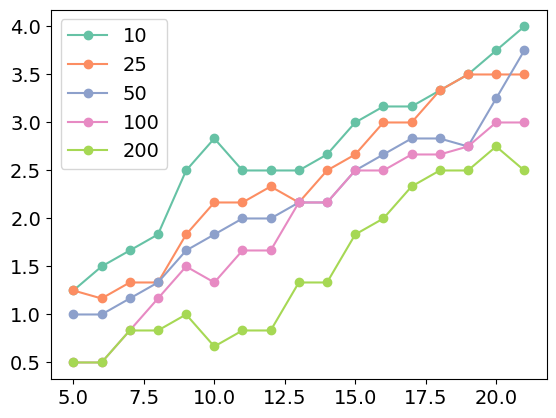

In [92]:
for i, p in enumerate(ps):
    plt.plot(sorted(results.keys()), [results[nq][kk]["best"][p]["delta_gamma"] for nq in sorted(results.keys())], marker="o", label=p, color=colors(i))
plt.legend()

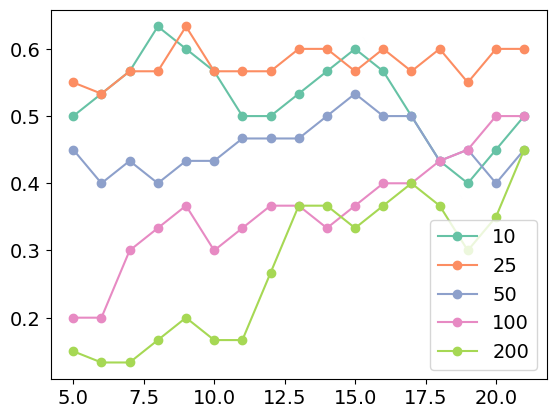

In [93]:
for i, p in enumerate(ps):
    plt.plot(sorted(results.keys()), [results[nq][kk]["best"][p]["delta_beta"] for nq in sorted(results.keys())], marker="o", label=p, color=colors(i))
plt.legend()

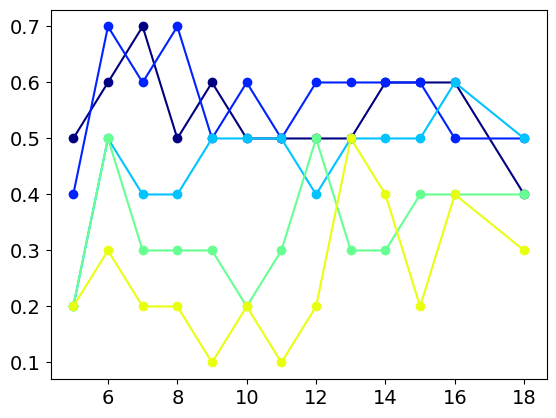

In [146]:

for i, p in enumerate(ps):
    plt.plot(results.keys(), [results[nq][kk]["best"][p]["delta_beta"] for nq in results.keys()], marker="o", label=p, color=colors(3*i))



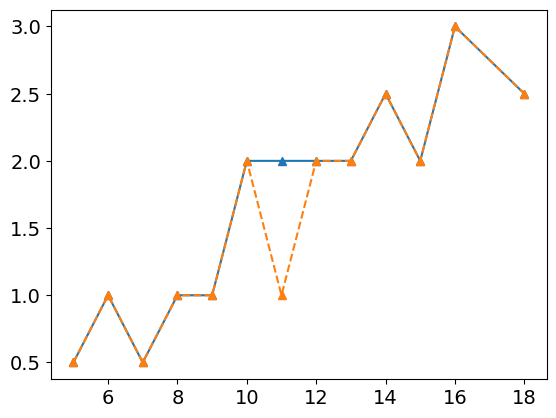

In [149]:
p=50
kk = 0
plt.plot(results.keys(), [results[nq][kk]["best"][p]["delta_gamma"] for nq in results.keys()], marker="^")
p=100
kk = 0
plt.plot(results.keys(), [results[nq][kk]["best"][p]["delta_gamma"] for nq in results.keys()], marker="^", linestyle="--")

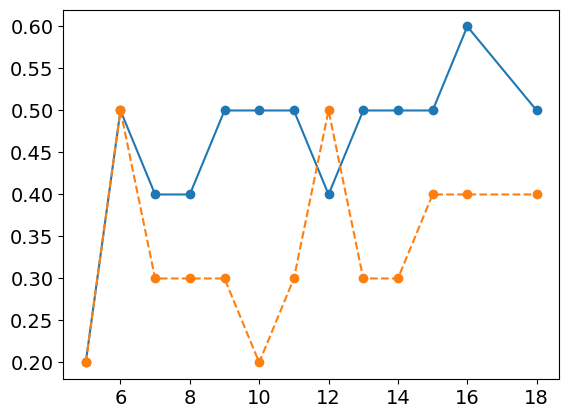

In [148]:
p=50
kk = 0
plt.plot(results.keys(), [results[nq][kk]["best"][p]["delta_beta"] for nq in results.keys()], marker="o")
p=100
kk = 0
plt.plot(results.keys(), [results[nq][kk]["best"][p]["delta_beta"] for nq in results.keys()], marker="o", linestyle="--")


In [85]:
results[nq][kk]["landscape"][p]["energy"]

array([[-5.266266, -5.253113, -5.196792, -5.156203, -5.10733 , -4.98474 ,
        -4.911587],
       [-5.270556, -5.284284, -5.28171 , -5.273988, -5.257411, -5.054265,
        -4.646544],
       [-5.245391, -5.28457 , -5.282854, -5.277998, -5.166275, -4.703126,
        -3.80368 ],
       [-5.208496, -5.283998, -5.280284, -5.228567, -5.073694, -4.118238,
        -2.830782],
       [-5.173899, -5.282282, -5.277428, -5.147417, -4.707956, -3.192761,
        -1.75957 ],
       [-5.133291, -5.281996, -5.22114 , -4.899973, -4.494245, -2.186405,
        -0.814943],
       [-5.100126, -5.278564, -5.136841, -4.709694, -3.688465, -1.258339,
        -0.206884]])

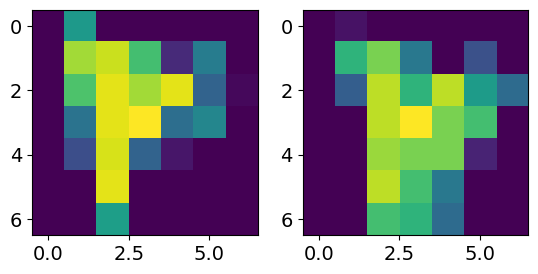

In [154]:
p = 100
nq = 18
fig, ax = plt.subplots(1,2)
ax[0].imshow(-results[nq][kk]["landscape"][p]["energy"], vmin=6, vmax=np.max(-results[nq][kk]["landscape"][p]["energy"]))
ax[1].imshow(results[nq][kk]["landscape"][p]["probability"], vmin= 0.8, vmax=np.max(results[nq][kk]["landscape"][p]["probability"]))

In [152]:
problems[nq][kk]["opt_energy"]


-6.1